# 1. import libraries

In [1]:
#! pip install splitfolders
#! pip install python_splitter 
#! pip install cv2
#! pip install opencv-python==4.6.0.66

In [2]:
import numpy as np
import nibabel as nib
import matplotlib.pyplot as plt
from ipywidgets import interact, interactive, IntSlider, ToggleButtons
from sklearn.preprocessing import MinMaxScaler #to scale image pixels
import pandas as pd
from skimage.filters import gaussian
import cv2
from scipy.signal import convolve2d
from skimage import io, img_as_float
from skimage.segmentation import active_contour
#import segmentation_models_3D as sm
scaler = MinMaxScaler()

In [3]:
#from google.colab import drive
#drive.mount('/content/drive')

In [4]:
#import os
#os.chdir(r"/content/drive/My Drive")

# 2. initial understanding of the dataset

In [5]:
DATASET_PATH = "C:/Users/jasmine/Desktop/graduation project/data/"

#load single image as numpy array
test_image_AD=nib.load( DATASET_PATH+ "AD_T2/ADNI/002_S_0619/Axial_PD_T2_FSE/2006-06-01_20_16_38.0/S15207/ADNI_002_S_0619_MR_Axial_PD_T2_FSE__br_raw_20060605133200599_2_S15207_I16498.nii").get_fdata()   # fdata Extract data as numpy ndarray
print(test_image_AD.max())  # we know that we need scale max=,min=0
print(test_image_AD.min())
print(test_image_AD.shape) # get dimentions of image(height, width, depth, channel )

7472.0
0.0
(256, 256, 54, 1)


### scaling

In [6]:
#Scalers are applied to 1D so let us reshape and then reshape back to original shape. 
test_image_AD=scaler.fit_transform(test_image_AD.reshape(-1, test_image_AD.shape[-1])).reshape(test_image_AD.shape)

test_image_CN=nib.load(DATASET_PATH + "CN_T2/ADNI/002_S_0295/Axial_PD_T2_FSE/2006-04-18_08_38_08.0/S13404/ADNI_002_S_0295_MR_Axial_PD_T2_FSE__br_raw_20060418201017471_2_S13404_I13723.nii").get_fdata()
test_image_CN=scaler.fit_transform(test_image_CN.reshape(-1, test_image_CN.shape[-1])).reshape(test_image_CN.shape)   #convert it to 1d and then to 3d again

test_image_MCI=nib.load(DATASET_PATH + "MCI_T2/ADNI/002_S_0729/Axial_PD_T2_FSE/2006-07-17_13_45_42.0/S16873/ADNI_002_S_0729_MR_Axial_PD_T2_FSE__br_raw_20060718015550509_2_S16873_I19059.nii").get_fdata()
test_image_MCI=scaler.fit_transform(test_image_MCI.reshape(-1, test_image_MCI.shape[-1])).reshape(test_image_MCI.shape)


print("AD MAX",test_image_AD.max()) 
print("AD SHAPE",test_image_AD.shape)
print("CN MAX",test_image_CN.max())  
print("CN SHAPE",test_image_CN.shape)
print("MCI MAX",test_image_MCI.max())  
print("MCI SHAPE",test_image_MCI.shape)
print("type",type(test_image_AD),type(test_image_CN),type(test_image_MCI))


AD MAX 1.0
AD SHAPE (256, 256, 54, 1)
CN MAX 1.0
CN SHAPE (256, 256, 52, 1)
MCI MAX 1.0
MCI SHAPE (256, 256, 48, 1)
type <class 'numpy.ndarray'> <class 'numpy.ndarray'> <class 'numpy.ndarray'>


### visualization

In [7]:
# Define a function to visualize the data
def explore_3dimage(layer):
    plt.figure(figsize=(10, 8))
    plt.subplot(231)
    plt.imshow(test_image_CN[:,:,layer], cmap='gray')
    plt.title('CN')
    plt.subplot(232)
    plt.imshow(test_image_MCI[:,:,layer], cmap='gray')
    plt.title('MCI')
    plt.subplot(233)
    plt.imshow(test_image_AD[:,:,layer], cmap='gray')
    plt.title('AD')
    plt.show()
    return layer

In [8]:

# Run the ipywidgets interact() function to explore the data
interact(explore_3dimage, layer=(0,47)); 

interactive(children=(IntSlider(value=23, description='layer', max=47), Output()), _dom_classes=('widget-inter…

# 3. preprocceing

## 3.1 slicing

In [9]:
def slicer(image):
    slice_index= range(image.shape[2])
    for ind in slice_index:
        slice_=image[:,:,slice_index[ind]]
        plt.figure(figsize=(5, 5))
        plt.imshow(slice_, cmap='gray')
    plt.show()

    
    ###########should return slice not print it need EDIT##########


    

##### test slicer function

In [ ]:
image_=slicer(test_image_AD)

### 3.2 skull stripping functions

In [18]:
def gausian_filter (image):
    gaussian_smoothed = gaussian(image)
    return gaussian_smoothed
################################################

def apply_conv(image,kernel):
    conv_ = cv2.filter2D(image, -1, kernel, borderType=cv2.BORDER_CONSTANT)
    return conv_
#################################################
def threshold(image):
    ##threshold image##
    [r,c]=image.shape
    for i in range(r) :
        for j in range (c) :
            if image[i,j]<=254: 
                image[i,j]=0
            else:
                image[i,j]=1
    return image
#################################################
def contour(image):
    s = np.linspace(0, 2*np.pi, 200)
    r = image.shape[0]*np.sin(s)
    c = image.shape[1]*np.cos(s)
    init = np.array([r, c]).T
    countered = active_contour(image,init, alpha=0.015, beta=10, gamma=0.001)
    return countered


#### test of gausian function

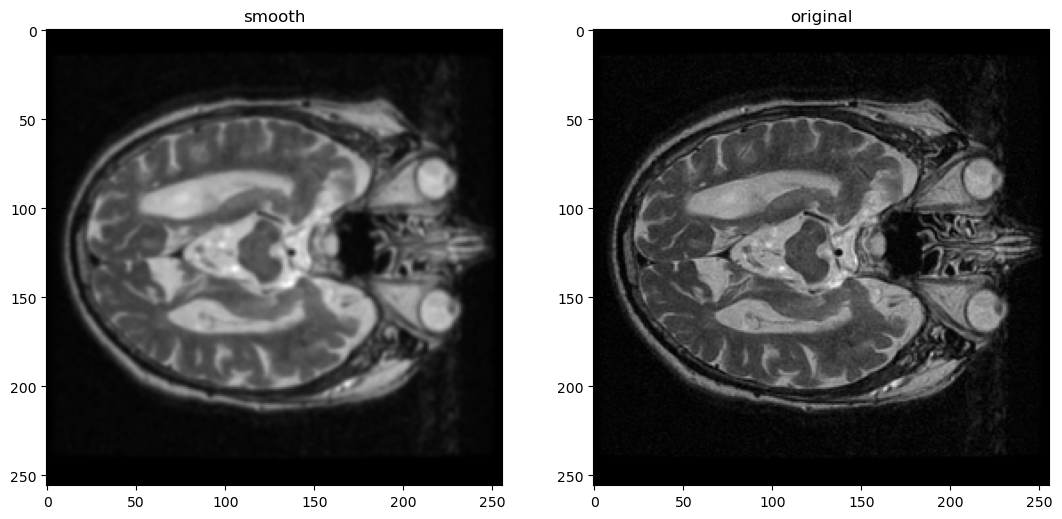

In [12]:

image=test_image_AD [:, :, 20]
smoothed=gausian_filter(image)
plt.figure(figsize=(20, 20))
plt.subplot(231)
plt.imshow(smoothed, cmap='gray')
plt.title('smooth')
plt.subplot(232)
plt.imshow(image, cmap='gray')
plt.title('original')
plt.show()

## 3.3 skull stripping

In [19]:
def skull_stripping(image):
    kernel = np.ones((3,3),np.float32)/9    #Averaging filter with 5x5 kernel
    gaussian_smoothed =gausian_filter(image) #I1
    conv_ = apply_conv(gaussian_smoothed,kernel) #I2
    th = threshold(conv_)
    erosion = cv2.erode(th,kernel,iterations = 1) #I3
    contour=(erosion) #I4
    out_image=image*contour #I5=I*I4

    return out_image

In [20]:
im=test_image_AD [:, :, 20,0]
kernel = np.ones((3,3),np.float32)/9    #Averaging filter with 5x5 kernel
smoothed=gausian_filter(im)
conv_using_cv2 = apply_conv(smoothed,kernel)
th=threshold(conv_using_cv2)
erosion = cv2.erode(th ,kernel,iterations = 1) 
contoured=contour(erosion)
[r,c]=conv_using_cv2.shape

#contour = active_contour(erosion,  alpha=0.015, beta=10, gamma=0.001)

'''plt.figure(figsize=(20, 20))
plt.subplot(231)
plt.imshow(conv_using_cv2, cmap='gray')
plt.title('conv')
plt.subplot(232)
plt.imshow(im, cmap='gray')
plt.title('original')
plt.subplot(233)
plt.imshow(erosion, cmap='gray')
plt.title('erosion')
plt.show()'''

"plt.figure(figsize=(20, 20))\nplt.subplot(231)\nplt.imshow(conv_using_cv2, cmap='gray')\nplt.title('conv')\nplt.subplot(232)\nplt.imshow(im, cmap='gray')\nplt.title('original')\nplt.subplot(233)\nplt.imshow(erosion, cmap='gray')\nplt.title('erosion')\nplt.show()"

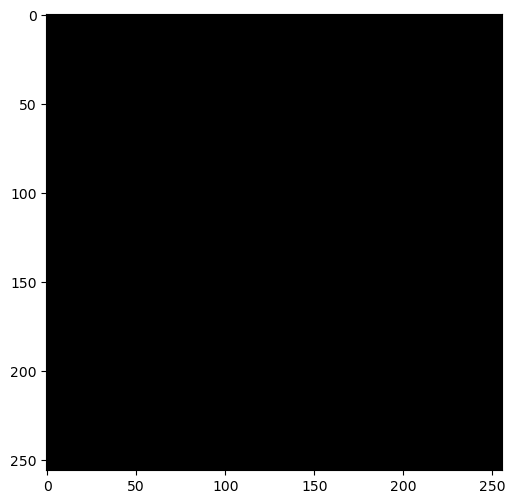

In [24]:

im_=test_image_AD [:, :, 35,0]
kernel = np.ones((3,3),np.float32)/9    #Averaging filter with 5x5 kernel
gaussian_smoothed=gaussian(im_) #I1
conv_ = cv2.filter2D(gaussian_smoothed, -1, kernel, borderType=cv2.BORDER_CONSTANT) #I2
th =threshold(conv_)
[r,c]=conv_.shape
'''
##threshold images##
def threshold(image):
    [r,c]=image.shape
    new_img=np.ones(r,c)
    for i in range(r) :
        for j in range (c) :
            if image[i,j]<=254: 
                new_img[i,j]=0
            else:
                new_img[i,j]=1
    return new_img
'''



    ##threshold image##
[r,c]=conv_.shape
for i in range(r) :
    for j in range (c) :
        if conv_[i,j]<=254: 
            conv_[i,j]=0
        else:
            conv_[i,j]=1

               
plt.figure(figsize=(20, 20))
plt.subplot(231)
plt.imshow(th, cmap='gray')
plt.show()
                

active contour

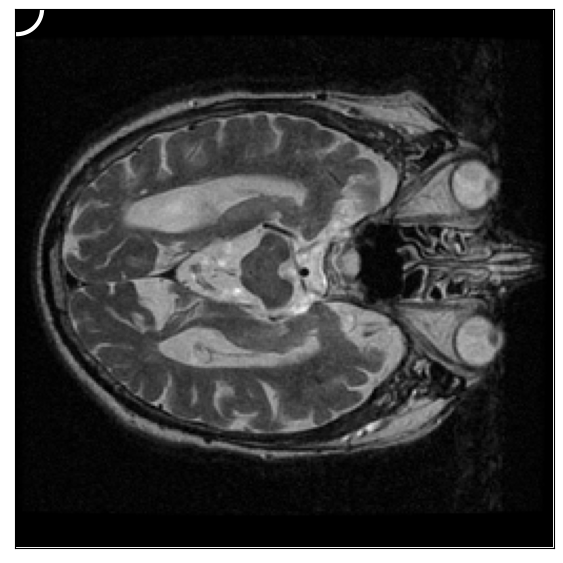

In [22]:
image = test_image_AD[:,:,20,0]


kernel = np.ones((3,3),np.float32)/9    #Averaging filter with 5x5 kernel
gaussian_smoothed =gausian_filter(image) #I1
conv_ = apply_conv(gaussian_smoothed,kernel) #I2
th = threshold(conv_)
erosion = cv2.erode(th,kernel,iterations = 1) #I3


s = np.linspace(0, 2*np.pi, 200)
r = image.shape[0]*np.sin(s)
c = image.shape[1]*np.cos(s)
init = np.array([r, c]).T
snake = active_contour(erosion,init, alpha=0.0015, beta=10, gamma=0.002)
fig, ax = plt.subplots(figsize=(7, 7))
ax.imshow(image, cmap=plt.cm.gray)
ax.plot(snake[:, 1], snake[:, 0], '-w', lw=3)
ax.set_xticks([]), ax.set_yticks([])
ax.axis([0, image.shape[1], image.shape[0], 0])
plt.show()